# Synthetic images generation and training tutorial with Medigan library

Import necessary libraries including MediganDataset

In [33]:
import monai
from monai.apps.datasets import MediganDataset
from monai.data import DataLoader
import torch
from torchmetrics.classification import BinaryAccuracy
import matplotlib.pyplot as plt
import numpy as np


### Create MediganDataset and generate synthetic data

In this tutorial, we will use conditional DCGAN model trained on Breast Imaging data.


Full list of avaialble models is avaialble at: https://github.com/RichardObi/medigan#available-models

In [42]:
model_id = '00008_C-DCGAN_MMG_MASSES'

temp_data_directory = "temp_dir"

train_synth_dataset = MediganDataset(temp_data_directory, model_id, 1000)
val_synth_dataset = MediganDataset(temp_data_directory, model_id, 200)

100%|██████████| 63/63 [00:07<00:00,  8.33it/s]
/Users/grzegorz/projects/MONAI/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
  warn_deprecated(argname, msg, warning_category)
Loading dataset: 100%|██████████| 1009/1009 [00:00<00:00, 3640.47it/s]


### Visualise some generated images

In this case, model generates grayscale images with size 128x128. It allows to create 'benign' and 'malignant' samples of images.

Generated image size: torch.Size([128, 128])


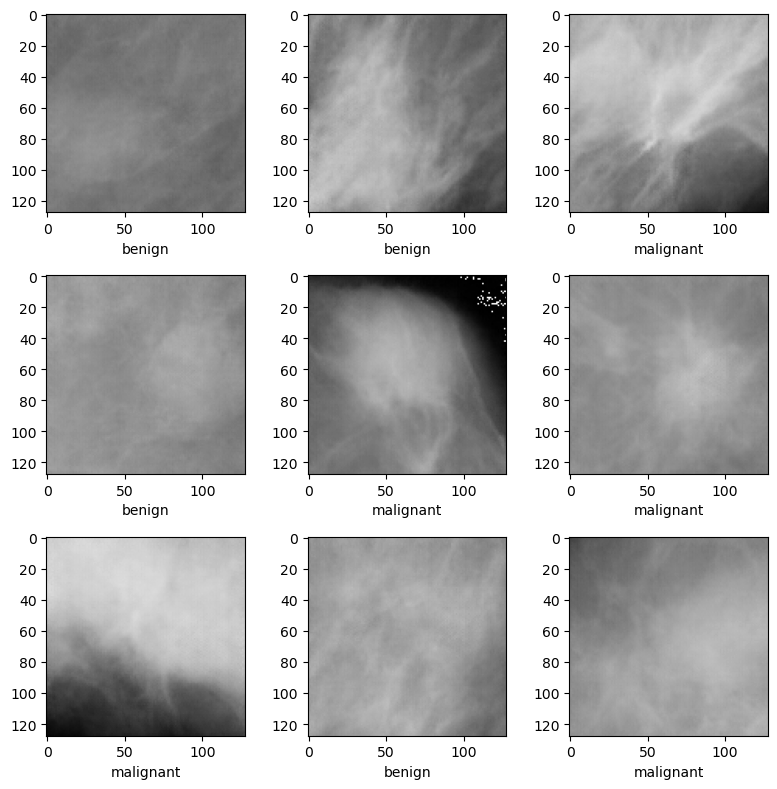

In [43]:
sample_image = train_synth_dataset[0]["image"]

print(f"Generated image size: {sample_image.shape}")

num_total = len(train_synth_dataset)
plt.subplots(3, 3, figsize=(8, 8))
for i, k in enumerate(np.random.randint(num_total, size=9)):
    sample = train_synth_dataset[i]
    arr = np.array(sample["image"])
    plt.subplot(3, 3, i + 1)
    plt.xlabel(sample["class_name"])
    plt.imshow(arr, cmap="gray", vmin=0, vmax=255)
plt.tight_layout()
plt.show()

### Train classification model with Pytorch

Create Dataloader

In [ ]:
batch_size = 16

train_loader = DataLoader(train_synth_dataset, batch_size=batch_size)
val_loader = DataLoader(val_synth_dataset, batch_size=batch_size)

Prepare training

In [ ]:
device = torch.device(f"cuda:0" if torch.cuda.is_available() else "cpu")
LEARN_RATE = 1e-4

model = monai.networks.nets.DenseNet121(spatial_dims=2, in_channels=1, out_channels=2, pretrained=True).to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), LEARN_RATE)

train_accuracy_metric = BinaryAccuracy().to(device)
accuracy_metric = BinaryAccuracy().to(device)


Train a model using generated data

In [24]:

# start a typical PyTorch training
MAX_EPOCHS = 10
val_interval = 1
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
for epoch in range(MAX_EPOCHS):
        print("-" * 10)
        print(f"epoch {epoch + 1}/{MAX_EPOCHS}")
        model.train()
        epoch_loss = 0
        step = 0

        for train_batch in train_loader:
            step += 1
            inputs, targets = train_batch["image"].to(device), train_batch["label"].to(
                device
            )
            inputs = inputs.unsqueeze(1)
            targets = torch.nn.functional.one_hot(torch.as_tensor(targets), num_classes=2).float()
            optimizer.zero_grad()
            preds = model(inputs)
            loss = loss_function(preds, targets)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            epoch_len = len(train_synth_dataset) // train_loader.batch_size
            targets = torch.argmax(targets, dim=1)
            preds = torch.argmax(preds, dim=1)
            train_accuracy = train_accuracy_metric(preds, targets)
            # print(
            #     f"{step}/{epoch_len}, train_loss: {loss.item():.4f} train_accuracy: {train_accuracy.item():.4f}"
            # )
            
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

        if (epoch + 1) % val_interval == 0:
            model.eval()
            val_loss = 0
            val_step = 0
            for val_batch in val_loader:
                val_step += 1
                val_images, targets = val_batch["image"].to(device), val_batch[
                    "label"
                ].to(device)
                with torch.no_grad():
                    val_images = val_images.unsqueeze(1)
                    preds = model(val_images)
                    targets = torch.nn.functional.one_hot(torch.as_tensor(targets), num_classes=2).float()
                    loss = loss_function(preds, targets)
                    targets = torch.argmax(targets, dim=1)
                    preds = torch.argmax(preds, dim=1)
                    val_loss += loss.item()
                    accuracy_metric.update(preds, targets)

            accuracy = accuracy_metric.compute().item()
            accuracy_metric.reset()
            metric = accuracy
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), f"best_model.pth")
                print("saved new best metric model")

            print(
                f"Current epoch: {epoch+1} acc: {accuracy:.4f}"
            )
            print(f"Best accuracy: {best_metric:.4f} at epoch {best_metric_epoch}")
            


----------
epoch 1/10
epoch 1 average loss: 0.7238
saved new best metric model
Current epoch: 1 acc: 0.5534
Best accuracy: 0.5534 at epoch 1
----------
epoch 2/10
epoch 2 average loss: 0.3543
saved new best metric model
Current epoch: 2 acc: 0.5922
Best accuracy: 0.5922 at epoch 2
----------
epoch 3/10
epoch 3 average loss: 0.1916
Current epoch: 3 acc: 0.5825
Best accuracy: 0.5922 at epoch 2
----------
epoch 4/10
epoch 4 average loss: 0.1585
Current epoch: 4 acc: 0.5631
Best accuracy: 0.5922 at epoch 2
----------
epoch 5/10
epoch 5 average loss: 0.1338
saved new best metric model
Current epoch: 5 acc: 0.6117
Best accuracy: 0.6117 at epoch 5
----------
epoch 6/10
epoch 6 average loss: 0.1058
Current epoch: 6 acc: 0.6019
Best accuracy: 0.6117 at epoch 5
----------
epoch 7/10
epoch 7 average loss: 0.0923
saved new best metric model
Current epoch: 7 acc: 0.6408
Best accuracy: 0.6408 at epoch 7
----------
epoch 8/10
epoch 8 average loss: 0.0723
Current epoch: 8 acc: 0.6117
Best accuracy: 0.